In this competition, we are given the daily sales for each item, for each shop. Competitors are to use the training set to predict sales for the test set. In addition to train & test files, we are given 3 other files (shops,items,cats) that provide additional information about each item.

We begin by importing all 5 files:

In [1]:
import pandas as pd
main = pd.read_csv("sales_train")
test = pd.read_csv("sales_test")
shops = pd.read_csv('shops')
items = pd.read_csv('items')
cats = pd.read_csv('item_categories')

Checking first 5 rows for train & test sets:

In [2]:
main.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Notice that only the train set has months (date_block_num).

Let's check for missing values:

In [69]:
#NULL DATA CHECK
#Check for missing values
main.isnull().sum()
#No columns contain null values

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

No missing values exist.

Next, we check for DATA LEAK. 
We check if all shop_ids in test also exist in train. 
We also check if all item_ids in test also exist in train.

In [70]:
#DATA LEAK
#We check if all shop_id in test is found in train
test['shop_id'].unique().any() not in main['shop_id'].unique().tolist()

False

In [71]:
#DATA LEAK
#We check if all item_id in test is found in train
test['item_id'].unique().any() not in main['item_id'].unique().tolist()

False

Interesting. 
Seems that all test data has been leaked to train data. 
This means that creating a proper prediction model using train data should give very good prediction accuracy for test data.

Let's see the description of train data:

In [4]:
main.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


Notice that 1 negative item_price exists.
item_cnt_day has negative values as well.
We need to do something about these values.

We remove outliers for item_price & item_cnt_day.
Kindly refer to EDA section on threshold values.

In [5]:
#THIS IS WHERE WE REMOVE OUTLIERS
#REFER TO EDA SECTION FOR CHOICE OF THRESHOLDS
leak_train = main
leak_train = leak_train[leak_train['item_price']<100000]
leak_train = leak_train[leak_train['item_cnt_day']<1001]
#There exist one negative price. Replace it with median
median = leak_train[(leak_train.shop_id==32)&(leak_train.item_id==2973)&(leak_train.date_block_num==4)&(leak_train.item_price>0)].item_price.median()
leak_train.loc[leak_train.item_price<0, 'item_price'] = median

Checking if negative item_price values still exist:

In [6]:
#Info for transaction with negative price
leak_train[leak_train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


Taking a look at train data description again, after removing outliers:

In [7]:
leak_train.describe().T

,count,mean,std,min,25%,50%,75%,max
date_block_num,2935847.0,14.569906,9.422985,0.00,7.0,14.0,23.0,33.0
shop_id,2935847.0,33.001743,16.226969,0.00,22.0,31.0,47.0,59.0
item_id,2935847.0,10197.228064,6324.299011,0.00,4476.0,9343.0,15684.0,22169.0
item_price,2935847.0,890.749575,1720.490363,0.07,249.0,399.0,999.0,59200.0
item_cnt_day,2935847.0,1.241903,2.292963,-22.00,1.0,1.0,1.0,1000.0


There exist some shops which are duplicates of each other.
Again, refer to EDA section for duplicates check.
We fix these duplicates with one unique value only.

In [8]:
#DATA PRE-PROCESSING
#REFER TO EDA SECTION FOR DUPLICATES CHECK
#Some shops are duplicates. We fix them with the same shop_id
leak_train.loc[leak_train['shop_id'] == 0,'shop_id'] = 57
test.loc[test['shop_id'] == 0,'shop_id'] = 57
leak_train.loc[leak_train['shop_id'] == 1,'shop_id'] = 58
test.loc[test['shop_id'] == 1,'shop_id'] = 58
leak_train.loc[leak_train['shop_id'] == 10,'shop_id'] = 11
test.loc[test['shop_id'] == 10,'shop_id'] = 11

Kindly pause here & run EDA section before continuing.

In [77]:
#RUN EDA SECTION FIRST BEFORE MOVING ON TO THE NEXT PART

Again, first part of shop_name is city name.
We can check this by separating first part out and googling them.

In [32]:
#DATA PRE-PROCESSING
#Let's check first part of shop_name
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

Some city names are not properly-written.
We fix them with the correct names before label-encoding them.

Similarly, for item_catagory_name, first part is the type, second part is the subtype.
We split them out before label-encoding them.

In [33]:
#DATA PRE-PROCESSING
#First part of shop_name is city name, except for 'Интернет-магазин'
#However, some city names are not properly-written. Let's fix them before label-encoding city names
from sklearn.preprocessing import LabelEncoder
shops.loc[shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops['city'] == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
#If subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

We check if test set includes every item_id for every shop_id, regardless if they are sold or not:

In [34]:
#DATA LEAK
print('No. of shops is {} & no. of unique items is {}.'.format(test['shop_id'].nunique(),test['item_id'].nunique()))
assert len(test) == test['shop_id'].nunique() * test['item_id'].nunique()

No. of shops is 42 & no. of unique items is 5100.


Interestingly, test set includes item pairs for every shop. However, train set only contains sold or returned items.
We need to replicate these pairs in the train set as well:

In [40]:
#DATA LEAK
from itertools import product
import numpy as np
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    leak_train_filtered = leak_train[leak_train['date_block_num'] == i]
    matrix.append(np.array(list(product([i], leak_train_filtered['shop_id'].unique(), leak_train_filtered['item_id'].unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

group = leak_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

main_combined = pd.merge(matrix, group, on=cols, how='left')
main_combined['item_cnt_month'] = (main_combined['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

We will need revenue for feature-engineering later:

In [35]:
#DATA PRE-PROCESSING
#Required for feature engineering
leak_train['revenue'] = leak_train['item_price'] *  leak_train['item_cnt_day']

In [38]:
#DATA PRE-PROCESSING
#Note that summing up item_cnt_month will return infinite since it exceeds maximum range
#import numpy as np
#np.sum(main_combined['item_cnt_month'])

Let's combine train & test sets together:

In [41]:
#DATA PRE-PROCESSING
#We do the same for test
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

main_combined = pd.concat([main_combined, test], sort=False,ignore_index=True, keys=cols)
main_combined.fillna(0, inplace=True)

Combining with shops,items,cats files:

In [42]:
#MERGE 
main_combined = pd.merge(main_combined, shops, on=['shop_id'], how='left')
main_combined = pd.merge(main_combined, items, on=['item_id'], how='left')
main_combined = pd.merge(main_combined, cats, on=['item_category_id'], how='left')

Checking first 5 rows of combined set:

In [43]:
main_combined.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0.0,0,40,11,4
1,0,2,27,1.0,0.0,0,19,5,10
2,0,2,28,0.0,0.0,0,30,8,55
3,0,2,29,0.0,0.0,0,23,5,16
4,0,2,32,0.0,0.0,0,40,11,4


START OF EDA SECTION

In [ ]:
#EXPLORATORY DATA ANALYSIS [FOR ORIGINAL DATASET]
#BASIC STATS

Again, looking at the description of train set:

In [9]:
#EXPLORATORY DATA ANALYSIS
main = leak_train
main.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06,2.935847e+06
mean,1.456991e+01,3.331065e+01,1.019723e+04,8.907496e+02,1.241903e+00
std,9.422985e+00,1.613679e+01,6.324299e+03,1.720490e+03,2.292963e+00
min,0.000000e+00,2.000000e+00,0.000000e+00,7.000000e-02,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.800000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.920000e+04,1.000000e+03


Let's see the unique values for each column:

In [10]:
#EXPLORATORY DATA ANALYSIS
#Features unique values
for col in main.columns:
    print("Number of unique values of {} : {}".format(col, main[col].nunique()))    

Number of unique values of date : 1034
Number of unique values of date_block_num : 34
Number of unique values of shop_id : 57
Number of unique values of item_id : 21806
Number of unique values of item_price : 19990
Number of unique values of item_cnt_day : 197


This data is over 34 months.
There are 57 different shops.
Many different item_ids, many repetitions.
Many different item_prices.

In [ ]:
#EXPLORATORY DATA ANALYSIS
#SALES/TRANSACTIONS TRENDS

Let's examine the trends for item_cnt_day sum,mean & count for each month for any seasonal effects:

[]

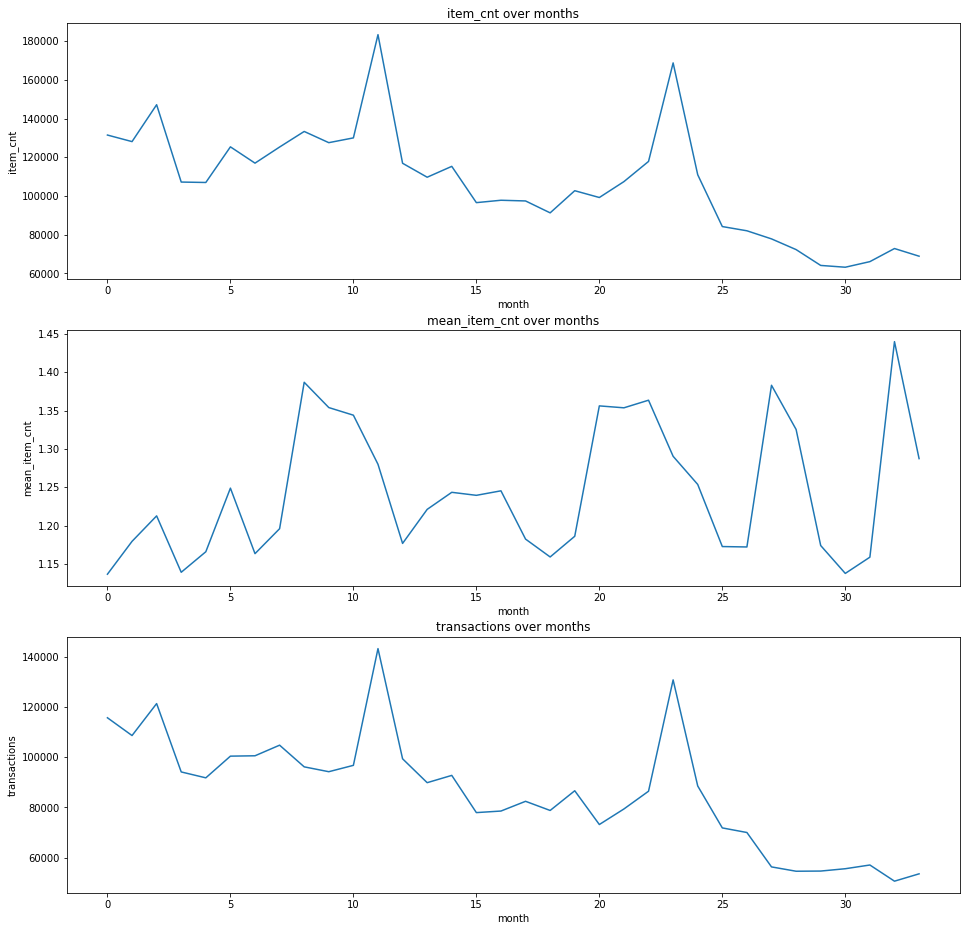

In [12]:
#EXPLORATORY DATA ANALYSIS
#Lets view the trend of item_cnt,mean_item_cnt,transactions over time
#We begin by importing matplotlib
ts = main.groupby('date_block_num')['item_cnt_day'].sum()
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('item_cnt over months')
plt.xlabel('month')
plt.ylabel('item_cnt')
plt.plot(ts)

ts = main.groupby('date_block_num')['item_cnt_day'].mean()
plt.subplot(312)
plt.title('mean_item_cnt over months')
plt.xlabel('month')
plt.ylabel('mean_item_cnt')
plt.plot(ts)
plt.plot()

ts = main.groupby('date_block_num')['date_block_num'].count()
plt.subplot(313)
plt.title('transactions over months')
plt.xlabel('month')
plt.ylabel('transactions')
plt.plot(ts)
plt.plot()

We observe 2 "spikes" in the data. They seem to be located at end of each year, implying seasonality/year effects.
Decreasing trend for item_cnt over months & transactions over months. 

Let's examine their distributions:

C:\Users\weiquan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[]

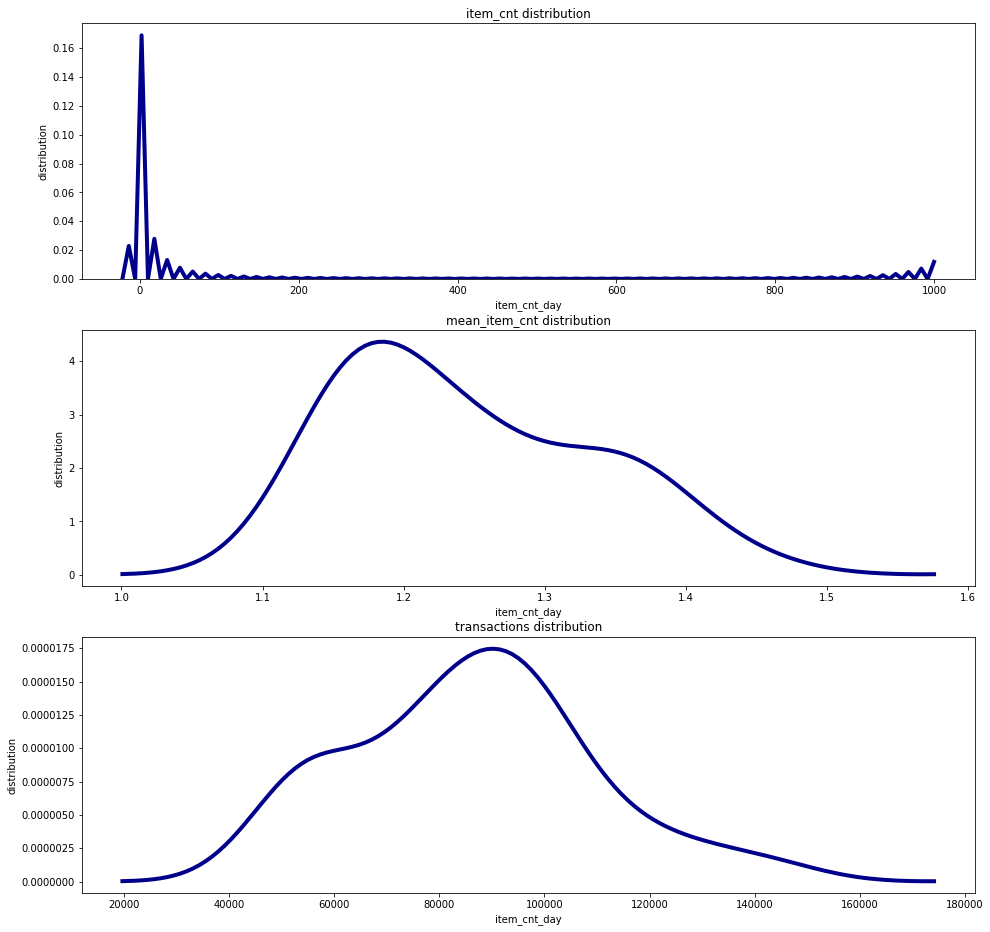

In [13]:
#EXPLORATORY DATA ANALYSIS
#Let's view the distribution of item_cnt,mean_item_cnt & transactions 
#We begin by importing seaborn
import seaborn as sns
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('item_cnt distribution')
plt.xlabel('item_cnt')
plt.ylabel('distribution')
sns.distplot(main['item_cnt_day'], hist=False, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})

plt.subplot(312)
plt.title('mean_item_cnt distribution')
plt.xlabel('mean_item_cnt')
plt.ylabel('distribution')
sns.distplot(main.groupby('date_block_num')['item_cnt_day'].mean(), hist=False, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.plot()

plt.subplot(313)
plt.title('transactions distribution')
plt.xlabel('transactions')
plt.ylabel('distribution')
sns.distplot(main.groupby('date_block_num')['item_cnt_day'].count(), hist=False, kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.plot()

#Data seems to be left-skewed, with most item sales averaging 1
#There seems to have 2 "bumps" for transactions, corrsponding to that of transactions over months

item_cnt_day seems to be heavily left-skewed.
mean_item_cnt & transactions seems to have fairly-normal distributions.

Let's examine the distribution of item_cnt sum BY shop_id

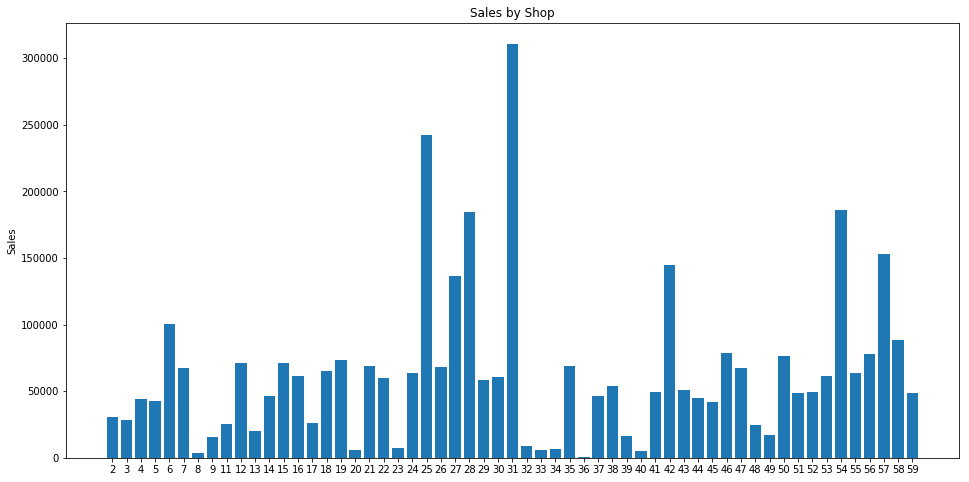

In [14]:
#EXPLORATORY DATA ANALYSIS
#Let's view the distribution of item_cnt BY shop_id
plt.figure(figsize=(16,8))
ts = main.groupby(['shop_id'],as_index=False)['item_cnt_day'].sum()
plt.title('Sales by Shop')
plt.bar(range(len(ts['item_cnt_day'])),list(ts['item_cnt_day']), align='center')
plt.xticks(range(len(ts['shop_id'])),list(ts['shop_id'].unique()))
plt.ylabel('Sales')
plt.show()
#Interestingly, most sales come from shop_id 31,25,28,42,57

Notice that only a few shops have large sales (31,25,28,54,57,42,27)

In [ ]:
#EXPLORATORY DATA ANALYSIS
#TIME SERIES STATIONARITY

There is clearly a seasonal trend.
However, we want to be sure that time-stationarity is preserved.
We can check this by de-trending the data to see if pattern is constant:

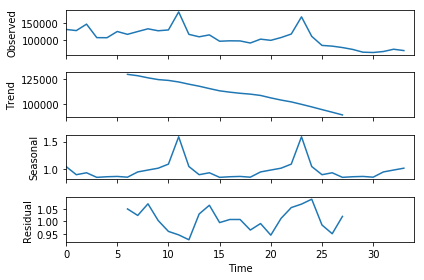

In [15]:
#EXPLORATORY DATA ANALYSIS
#Seems like seasonality is involved
#We check using multiplicative model
ts = main.groupby(['date_block_num'])['item_cnt_day'].sum()
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
fig = res.plot()

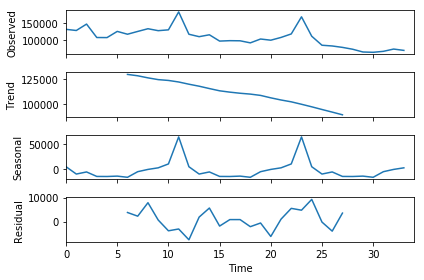

In [16]:
#EXPLORATORY DATA ANALYSIS
#Now we check usng additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()

Notice that both models show spikes only at year's end after removal of decreasing trend.
Time-stationarity exists and we can safely-proceed to further analyse this time-series.

To be extra-sure, we can perform Dickey-Fuller test after de-trending for hypothesis testing:

In [17]:
#EXPLORATORY DATA ANALYSIS
#We create a function for de-trending
from statsmodels.tsa.stattools import adfuller
def difference(dataset,interval=1):
    diff = list()
    for i in range(interval,len(dataset)):
        difference = dataset[i] - dataset[i-interval]
        diff.append(difference)
    return pd.Series(diff)

#We create a function for checking stationarity
def test_stationarity(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


Notice that p-value is large before de-trending:

In [18]:
#EXPLORATORY DATA ANALYSIS
#We create a temp. sum of item_cnt_day for each month
ts = main.groupby(['date_block_num'])['item_cnt_day'].sum()
#Let's check stationarity for original summed data
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.368978
p-value                         0.150684
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


Let's de-trend & de-seasonalise the data before checking for stationarity.
Here, we assume a 12-months seasonal effect:

[]

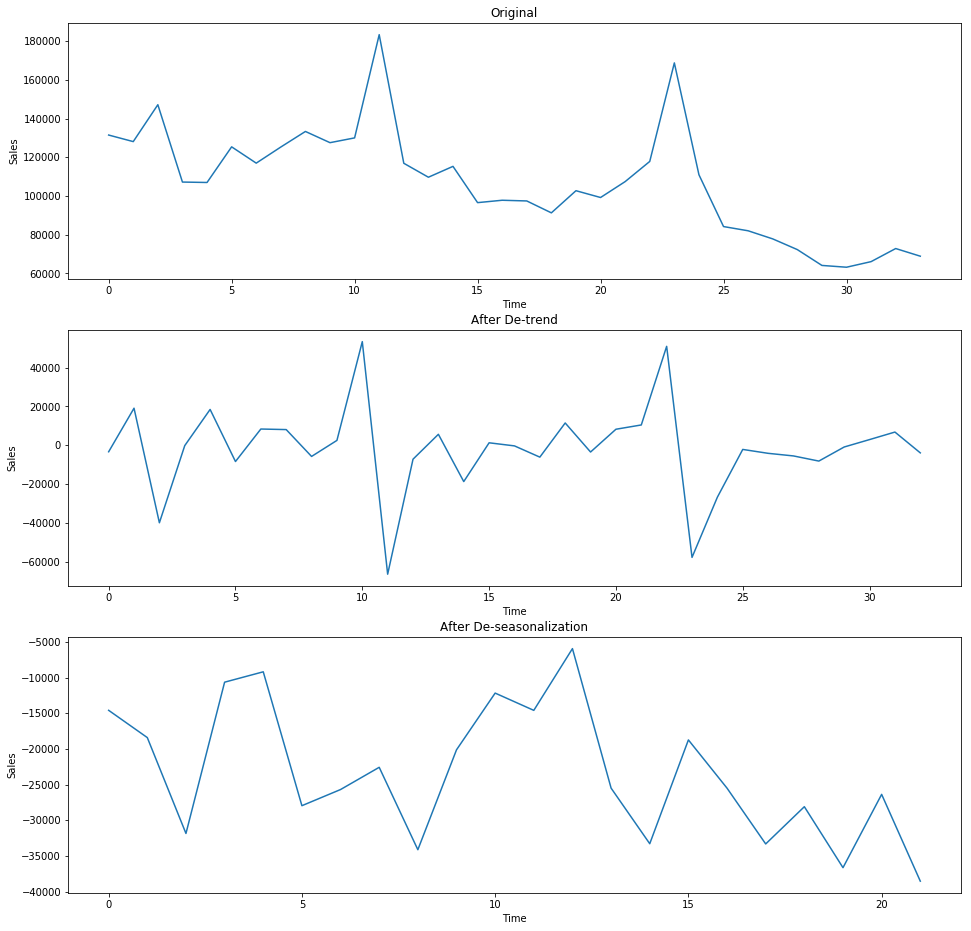

In [19]:
#EXPLORATORY DATA ANALYSIS
#Let's de-trend and print 
import matplotlib.pyplot as plt
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

plt.subplot(312)
ts_new = difference(ts)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts_new)
plt.plot()

plt.subplot(313)
ts_new = difference(ts,12)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts_new)
plt.plot()

Data seems to exhibit time-stationarity after de-trending & de-seasonalisation.

Let's perform Dickey-Fuller test again:

In [20]:
#EXPLORATORY DATA ANALYSIS
#Let's check stationarity for de-seasonlised data
test_stationarity(ts_new)

Results of Dickey-Fuller Test:
Test Statistic                 -3.194056
p-value                         0.020331
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


Notice that p-value is less than 5.
We can safely-reject the hypothesis that time-stationarity does not exist.

Let's check for outliers using violin plots, starting with item_cnt_day.
We use violin plots as they show distribution & density of values.

C:\Users\weiquan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


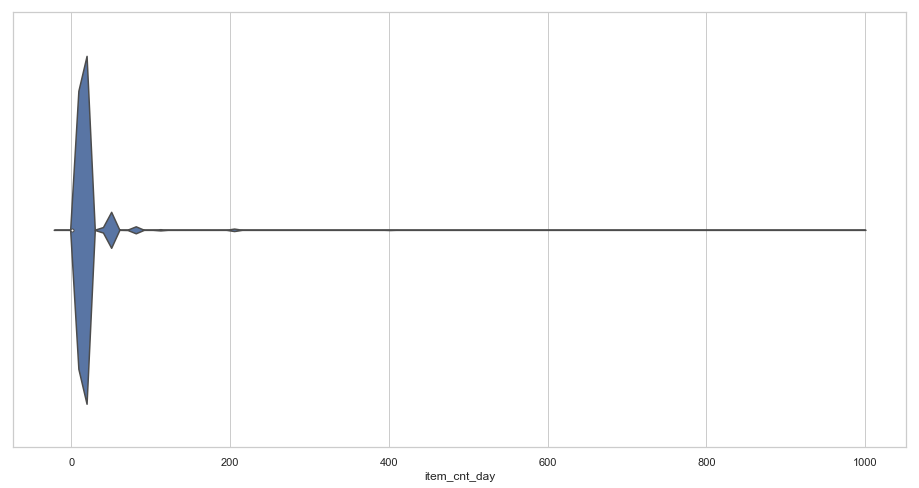

In [21]:
#EXPLORATORY DATA ANALYSIS
#OUTLIERS [item_cnt]
import seaborn as sns
plt.figure(figsize=(16,8))
sns.set(style="whitegrid")
sns.violinplot(x=main["item_cnt_day"])
#There seems to be some outliers, with most points = 1

There's clearly some outliers exceeding 1000. 
We shall use 1000 as our threshold for item_cnt_day.

Next, we look at the violin plot for item_price

C:\Users\weiquan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


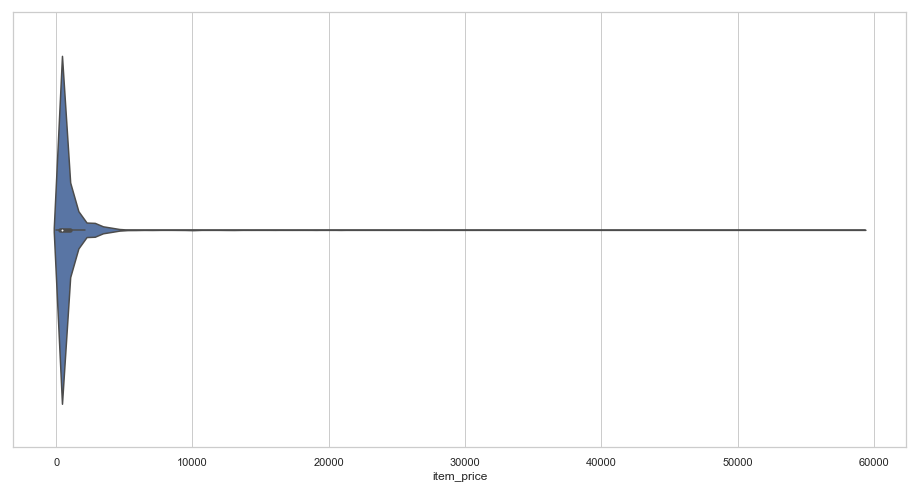

In [22]:
#EXPLORATORY DATA ANALYSIS
#OUTLIERS [item_price]
import seaborn as sns
plt.figure(figsize=(16,8))
sns.set(style="whitegrid")
sns.violinplot(x=main["item_price"])

There are clearly negative values as well as values exceeding 60000.
We shall use 100000 as threshold and see if the remaining data can give a good accuracy.

Let's move on to shop_name:

First part of shop_name is the city name, second part of shop_name is the actual shop name.
There exist shops with similar names:

In [24]:
#EXPLORATORY DATA ANALYSIS
#SHOPS
shops['temp'] = shops['shop_name'].str.split(' ').map(lambda x: x[1])
for i in shops['temp'].unique():
    if shops[shops['temp'] == i]['shop_id'].nunique() > 1:
        print(i)
#These are the shops with similar names    

Орджоникидзе,
ТЦ
ТРК
ТРЦ
ул.
ТК


In [25]:
#EXPLORATORY DATA ANALYSIS
#Among these, these 3 are the same:
#'!Якутск Орджоникидзе, 56 фран' & 'Якутск Орджоникидзе, 56'
shops[shops['temp'] == 'Орджоникидзе,']['shop_name'].unique()

array(['!Якутск Орджоникидзе, 56 фран', 'Якутск Орджоникидзе, 56'],
      dtype=object)

In [26]:
#EXPLORATORY DATA ANALYSIS
#Getting their shop_id:
shops[shops['shop_name'].isin(['!Якутск Орджоникидзе, 56 фран','Якутск Орджоникидзе, 56'])]['shop_id'].unique()

array([ 0, 57], dtype=int64)

In [27]:
#EXPLORATORY DATA ANALYSIS
#'!Якутск ТЦ "Центральный" фран' & 'Якутск ТЦ "Центральный"'
shops[shops['temp'] == 'ТЦ']['shop_name'].unique()

array(['!Якутск ТЦ "Центральный" фран', 'Адыгея ТЦ "Мега"',
       'Волжский ТЦ "Волга Молл"', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Коломна ТЦ "Рио"',
       'Красноярск ТЦ "Взлетка Плаза"', 'Красноярск ТЦ "Июнь"',
       'Курск ТЦ "Пушкинский"', 'Москва ТЦ "Ареал" (Беляево)',
       'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва ТЦ "Семеновский"', 'Москва ТЦ "Серебряный Дом"',
       'Новосибирск ТЦ "Мега"', 'Омск ТЦ "Мега"',
       'РостовНаДону ТЦ "Мега"', 'Самара ТЦ "Мелодия"',
       'Самара ТЦ "ПаркХаус"', 'Тюмень ТЦ "Гудвин"',
       'Тюмень ТЦ "Зеленый Берег"', 'Уфа ТЦ "Семья" 2', 'Химки ТЦ "Мега"',
       'Якутск ТЦ "Центральный"', 'Ярославль ТЦ "Альтаир"'], dtype=object)

In [28]:
#EXPLORATORY DATA ANALYSIS
#Getting their shop_id:
shops[shops['shop_name'].isin(['!Якутск ТЦ "Центральный" фран' ,'Якутск ТЦ "Центральный"'])]['shop_id'].unique()

array([ 1, 58], dtype=int64)

In [29]:
#EXPLORATORY DATA ANALYSIS
#'Жуковский ул. Чкалова 39м?' & 'Жуковский ул. Чкалова 39м²'
shops[shops['temp'] == 'ул.']['shop_name'].unique()

array(['Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²'],
      dtype=object)

In [30]:
#EXPLORATORY DATA ANALYSIS
#Getting their shop_id:
shops[shops['shop_name'].isin([ 'Жуковский ул. Чкалова 39м?','Жуковский ул. Чкалова 39м²'])]['shop_id'].unique()

array([10, 11], dtype=int64)

Notice that these shops with similar names have 2 different shop_ids.
We fix this by setting them to 1 shop_id only.

END OF EDA SECTION

Taking a look at first 5 rows of combined set again:

In [44]:
main_combined.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0.0,0,40,11,4
1,0,2,27,1.0,0.0,0,19,5,10
2,0,2,28,0.0,0.0,0,30,8,55
3,0,2,29,0.0,0.0,0,23,5,16
4,0,2,32,0.0,0.0,0,40,11,4


START OF FE SECTION

There are various ways to do feature-engineering.
Here, we start by creating 3 lags for item_cnt_month:

In [45]:
#FEATURE ENGINEERING
#TARGET LAG
#Using it as lag feature
#We use lags=3 for now
lag = main_combined[['date_block_num','shop_id','item_id', 'item_cnt_month']].copy()
for i in range(1,4):
    lag.columns = ['date_block_num','shop_id','item_id', 'item_cnt_month_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined['item_cnt_month_lag_1'].fillna(0, inplace=True) 
main_combined['item_cnt_month_lag_2'].fillna(0, inplace=True) 
main_combined['item_cnt_month_lag_3'].fillna(0, inplace=True) 

Taking a look at first 5 rows after creating the 3 lags:

In [46]:
#FEATURE ENGINEERING
#MEANS ENCODING
main_combined.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,2,19,0.0,0.0,0,40,11,4,0.0,0.0,0.0
1,0,2,27,1.0,0.0,0,19,5,10,0.0,0.0,0.0
2,0,2,28,0.0,0.0,0,30,8,55,0.0,0.0,0.0
3,0,2,29,0.0,0.0,0,23,5,16,0.0,0.0,0.0
4,0,2,32,0.0,0.0,0,40,11,4,0.0,0.0,0.0


The following is to check correlation between different features.
It is optional to run this since it may be computationally-intensive.

Correlation of item_cnt_month mean with each feature:

In [48]:
#FEATURE ENGINEERING [DO NOT RUN]
#SELECTING VARIABLES [1st Level]
from itertools import combinations
for i in main_combined.columns:
    mean = main_combined.groupby([i]).agg({'item_cnt_month': ['mean']})
    mean.columns = ['avg_item_cnt']
    mean.reset_index(inplace=True)
    print("CorrCoef of {} is {}".format(i,mean['avg_item_cnt'].corr(main_combined['item_cnt_month'])))

CorrCoef of date_block_num is 0.06556905037429067
CorrCoef of shop_id is -0.08250730996706716
CorrCoef of item_id is -0.005967479004912032
CorrCoef of item_cnt_month is -0.375059803843774
CorrCoef of ID is -0.0005722315434310809
CorrCoef of city_code is 0.03497691079800548
CorrCoef of item_category_id is 0.01364866993602766
CorrCoef of type_code is -0.07103573027706936
CorrCoef of subtype_code is -0.027666016994273422
CorrCoef of item_cnt_month_lag_1 is -0.3759287032567221
CorrCoef of item_cnt_month_lag_2 is -0.37627824172701757
CorrCoef of item_cnt_month_lag_3 is -0.37583043298718244


Correlation of item_cnt_month mean with feature pairs:

In [25]:
#FEATURE ENGINEERING [DO NOT RUN]
#SELECTING VARIABLES [2nd Level]
for i in combinations(main_combined.columns,2):
    mean = main_combined.groupby([i[0],i[1]]).agg({'item_cnt_month': ['mean']})
    mean.columns = ['avg_item_cnt']
    mean.reset_index(inplace=True)
    print("CorrCoef of {} and {} is {}".format(i[0],i[1],mean['avg_item_cnt'].corr(main_combined['item_cnt_month'])))

CorrCoef of date_block_num and shop_id is 0.006675314799036736
CorrCoef of date_block_num and item_id is 0.009519247460112854
CorrCoef of date_block_num and item_cnt_month is 0.00807134414197245
CorrCoef of date_block_num and ID is -0.0033941463376048597
CorrCoef of date_block_num and city_code is 0.02532686794124232
CorrCoef of date_block_num and item_category_id is 0.0066839143002622526
CorrCoef of date_block_num and type_code is -0.022673341642333793
CorrCoef of date_block_num and subtype_code is 0.019765925363616595
CorrCoef of date_block_num and item_cnt_month_lag_1 is -0.01419447249748323
CorrCoef of date_block_num and item_cnt_month_lag_2 is -0.006266204140742783
CorrCoef of date_block_num and item_cnt_month_lag_3 is 0.0012720640258968628
CorrCoef of shop_id and item_id is 0.0016969723207861445
CorrCoef of shop_id and item_cnt_month is -0.009902508367535772
CorrCoef of shop_id and ID is 0.0033472504854204616
CorrCoef of shop_id and city_code is -0.038236993745493816
CorrCoef of 

Correlation of item_cnt_month mean with feature triples:

In [49]:
#FEATURE ENGINEERING [DO NOT RUN]
#SELECTING VARIABLES [3rd Level]
for i in combinations(main_combined.columns,3):
    mean = main_combined.groupby([i[0],i[1],i[2]]).agg({'item_cnt_month': ['mean']})
    mean.columns = ['avg_item_cnt']
    mean.reset_index(inplace=True)
    print("CorrCoef of {} , {} and {} is {}".format(i[0],i[1],i[2],mean['avg_item_cnt'].corr(main_combined['item_cnt_month'])))

CorrCoef of date_block_num , shop_id and item_id is 1.0
CorrCoef of date_block_num , shop_id and item_cnt_month is -0.006026582572708788
CorrCoef of date_block_num , shop_id and ID is -0.0047535625049314
CorrCoef of date_block_num , shop_id and city_code is -0.014389526410167617
CorrCoef of date_block_num , shop_id and item_category_id is -0.0043489084378267534
CorrCoef of date_block_num , shop_id and type_code is 0.0035318834123218446
CorrCoef of date_block_num , shop_id and subtype_code is 0.007698099832121907
CorrCoef of date_block_num , shop_id and item_cnt_month_lag_1 is -0.017431394078786366
CorrCoef of date_block_num , shop_id and item_cnt_month_lag_2 is -0.003391363077167163
CorrCoef of date_block_num , shop_id and item_cnt_month_lag_3 is -0.011925059168126714
CorrCoef of date_block_num , item_id and item_cnt_month is 0.0022759015351455315
CorrCoef of date_block_num , item_id and ID is 0.015310768643224802
CorrCoef of date_block_num , item_id and city_code is -0.000964159005601

CorrCoef of item_id , item_cnt_month and city_code is 0.002885555902625853
CorrCoef of item_id , item_cnt_month and item_category_id is -0.013462315955478036
CorrCoef of item_id , item_cnt_month and type_code is -0.013462315955478036
CorrCoef of item_id , item_cnt_month and subtype_code is -0.013462315955478036
CorrCoef of item_id , item_cnt_month and item_cnt_month_lag_1 is -0.0029257827157587253
CorrCoef of item_id , item_cnt_month and item_cnt_month_lag_2 is -0.01229640765277656
CorrCoef of item_id , item_cnt_month and item_cnt_month_lag_3 is 0.004750620572776558
CorrCoef of item_id , ID and city_code is -0.0005342732831800403
CorrCoef of item_id , ID and item_category_id is -0.002905082890759696
CorrCoef of item_id , ID and type_code is -0.002905082890759696
CorrCoef of item_id , ID and subtype_code is -0.002905082890759696
CorrCoef of item_id , ID and item_cnt_month_lag_1 is -0.0046472152752636145
CorrCoef of item_id , ID and item_cnt_month_lag_2 is -0.003328504911380423
CorrCoef 

CorrCoef of item_category_id , type_code and subtype_code is 0.01364866993602766
CorrCoef of item_category_id , type_code and item_cnt_month_lag_1 is -0.0015180272180736018
CorrCoef of item_category_id , type_code and item_cnt_month_lag_2 is -0.01312175851956482
CorrCoef of item_category_id , type_code and item_cnt_month_lag_3 is 0.029344146449648913
CorrCoef of item_category_id , subtype_code and item_cnt_month_lag_1 is -0.0015180272180736018
CorrCoef of item_category_id , subtype_code and item_cnt_month_lag_2 is -0.01312175851956482
CorrCoef of item_category_id , subtype_code and item_cnt_month_lag_3 is 0.029344146449648913
CorrCoef of item_category_id , item_cnt_month_lag_1 and item_cnt_month_lag_2 is 0.013419974322680222
CorrCoef of item_category_id , item_cnt_month_lag_1 and item_cnt_month_lag_3 is -0.008723612060038235
CorrCoef of item_category_id , item_cnt_month_lag_2 and item_cnt_month_lag_3 is 0.005378531619941314
CorrCoef of type_code , subtype_code and item_cnt_month_lag_1 

We use mean item_cnt for each month as lag variable:

In [50]:
#FEATURE ENGINEERING
#We add mean item_cnt for each month as lag variable
group = main_combined.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)
main_combined = pd.merge(main_combined, group, on=['date_block_num'], how='left')
main_combined['date_avg_item_cnt'] = main_combined['date_avg_item_cnt'].astype(np.float16)

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id', 'date_avg_item_cnt']].copy()
lag.columns = ['date_block_num','shop_id','item_id', 'date_avg_item_lag_1']
lag['date_block_num'] += 1
main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_avg_item_lag_1'].fillna(0, inplace=True)  

We use mean item_cnt for each item_id,for each month as lag variable.
We use lags 1,2,3,6,12.

In [51]:
#FEATURE ENGINEERING
#We add mean item_cnt for each item_id for each month as lag variable
group = main_combined.groupby(['date_block_num','item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)
main_combined = pd.merge(main_combined, group, on=['date_block_num','item_id'], how='left')
main_combined['date_item_avg_item_cnt'] = main_combined['date_item_avg_item_cnt'].astype(np.float16)

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id', 'date_item_avg_item_cnt']].copy()
lis = [1,2,3,6,12]
for i in lis:
    lag.columns = ['date_block_num','shop_id','item_id', 'date_item_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_item_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_item_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_item_avg_item_lag_3'].fillna(0, inplace=True) 
main_combined['date_item_avg_item_lag_6'].fillna(0, inplace=True) 
main_combined['date_item_avg_item_lag_12'].fillna(0, inplace=True) 

We use mean item_cnt for each shop_id,for each month as lag variable.
We use lags 1,2,3,6,12.

In [52]:
#FEATURE ENGINEERING
#We add mean item_cnt for each shop_id for each month as lag variable
#Seems like many lags have strong correlation with date_shop_avg_item_cnt
#We shall use 3 lags for now
group = main_combined.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','shop_id'], how='left')

#Using it as lag feature
lis = [1,2,3,6,12]
lag = main_combined[['date_block_num','shop_id','item_id', 'date_shop_avg_item_cnt']].copy()
for i in lis:
    lag.columns = ['date_block_num','shop_id','item_id', 'date_shop_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_shop_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_shop_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_shop_avg_item_lag_3'].fillna(0, inplace=True) 
main_combined['date_shop_avg_item_lag_6'].fillna(0, inplace=True) 
main_combined['date_shop_avg_item_lag_12'].fillna(0, inplace=True) 

We use mean item_cnt for each item_category_id,for each month as lag variable.
We use lags 1,2,3,6,12.

In [53]:
#FEATURE ENGINEERING 
#We add mean item_cnt for each item_category_id as lag variable
group = main_combined.groupby(['date_block_num','item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_category_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','item_category_id'], how='left')
main_combined['date_item_category_avg_item_cnt'] = main_combined['date_item_category_avg_item_cnt'].astype(np.float16)

#Using it as lag feature
lis = [1,2,3,6,12]
lag = main_combined[['date_block_num','shop_id','item_id','date_item_category_avg_item_cnt']].copy()
for i in lis:
    lag.columns = ['date_block_num','shop_id','item_id','date_item_category_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_item_category_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_item_category_avg_item_lag_1'].fillna(0, inplace=True) 
main_combined['date_item_category_avg_item_lag_2'].fillna(0, inplace=True) 
main_combined['date_item_category_avg_item_lag_3'].fillna(0, inplace=True) 
main_combined['date_item_category_avg_item_lag_6'].fillna(0, inplace=True) 
main_combined['date_item_category_avg_item_lag_12'].fillna(0, inplace=True) 

We use mean item_cnt for each city, for each month as lag variable:

In [54]:
#FEATURE ENGINEERING 
#We add mean item_cnt for each city_code for each month
group = main_combined.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'city_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id','date_city_avg_item_cnt']].copy()
for i in range(1,2):
    lag.columns = ['date_block_num','shop_id','item_id','date_city_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_city_avg_item_lag_1'].fillna(0, inplace=True) 

We use mean item_cnt for each type, for each month as lag variable:

In [55]:
#FEATURE ENGINEERING 
#We add mean item_cnt for each type_code
group = main_combined.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'type_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id','date_type_avg_item_cnt']].copy()
for i in range(1,2):
    lag.columns = ['date_block_num','shop_id','item_id','date_type_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_type_avg_item_lag_1'].fillna(0, inplace=True) 

We use mean item_cnt for each subtype, for each month as lag variable:

In [56]:
#FEATURE ENGINEERING 
#We add mean item_cnt for each subtype_code
group = main_combined.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_subtype_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'subtype_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id','date_subtype_avg_item_cnt']].copy()
for i in range(1,2):
    lag.columns = ['date_block_num','shop_id','item_id','date_subtype_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_subtype_avg_item_lag_1'].fillna(0, inplace=True) 

We use mean item_cnt for each category_id, for each shop_id, for each month as lag variable:

In [57]:
#FEATURE ENGINEERING
#We add mean item_cnt for each item_category_id as lag variable
group = main_combined.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','shop_id', 'item_category_id'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id','date_shop_cat_avg_item_cnt']].copy()
for i in range(1,2):
    lag.columns = ['date_block_num','shop_id','item_id','date_shop_cat_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_shop_cat_avg_item_lag_1'].fillna(0, inplace=True) 

We use mean item_cnt for each type, for each shop_id, for each month as lag variable:

In [58]:
#FEATURE ENGINEERING 
#We add mean item_cnt for each shop_id for each type_code
group = main_combined.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','shop_id', 'type_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id','date_shop_type_avg_item_cnt']].copy()
for i in range(1,2):
    lag.columns = ['date_block_num','shop_id','item_id','date_shop_type_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_shop_type_avg_item_lag_1'].fillna(0, inplace=True)  

We use mean item_cnt for each subtype, for each shop_id, for each month as lag variable:

In [59]:
#FEATURE ENGINEERING 
#We add mean item_cnt for each shop_id for each subtype_code for each month
group = main_combined.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id','date_shop_subtype_avg_item_cnt']].copy()
for i in range(1,2):
    lag.columns = ['date_block_num','shop_id','item_id','date_shop_subtype_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_shop_subtype_avg_item_lag_1'].fillna(0, inplace=True) 

We use mean item_cnt for each item_id, for each city, for each month as lag variable:

In [60]:
#FEATURE ENGINEERING 
#We add mean item_cnt for each item_id for each city_code
group = main_combined.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num', 'item_id','city_code'], how='left')

#Using it as lag feature
lag = main_combined[['date_block_num','shop_id','item_id','date_item_city_avg_item_cnt']].copy()
for i in range(1,2):
    lag.columns = ['date_block_num','shop_id','item_id','date_item_city_avg_item_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

#Drop date_avg_item_cnt
main_combined.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
main_combined['date_item_city_avg_item_lag_1'].fillna(0, inplace=True) 

We create 6 lags & select the latest lag that is not null as trend:

In [61]:
#FEATURE ENGINEERING
#TRENDS
#For each item_id
group = leak_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['item_id'], how='left')
main_combined['item_avg_item_price'] = main_combined['item_avg_item_price'].astype(np.float16)

group = leak_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

#For each month, for each item_id
main_combined = pd.merge(main_combined, group, on=['date_block_num','item_id'], how='left')
main_combined['date_item_avg_item_price'] = main_combined['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
for i in range(1,7):
    lag.columns = ['date_block_num','shop_id','item_id','date_item_avg_item_price_lag_'+str(i)]
    lag['date_block_num'] += 1
    main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

for i in lags:
    main_combined['delta_price_lag_'+str(i)] = \
        (main_combined['date_item_avg_item_price_lag_'+str(i)] - main_combined['item_avg_item_price']) / main_combined['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
main_combined['delta_price_lag'] = main_combined.apply(select_trend, axis=1)
main_combined['delta_price_lag'] = main_combined['delta_price_lag'].astype(np.float16)
main_combined['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

main_combined.drop(fetures_to_drop, axis=1, inplace=True)



We calculate shop revenue for each month & average shop revenue.
We then take the difference divided by average shop revenue and use the result as lag variable:

In [62]:
#FEATURE ENGINEERING
#TRENDS
#For each month, each shop_id's revenue
group = leak_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['date_block_num','shop_id'], how='left')
main_combined['date_shop_revenue'] = main_combined['date_shop_revenue'].astype(np.float32)

#For each shop_id's revenue
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

main_combined = pd.merge(main_combined, group, on=['shop_id'], how='left')
main_combined['shop_avg_revenue'] = main_combined['shop_avg_revenue'].astype(np.float32)

main_combined['delta_revenue'] = (main_combined['date_shop_revenue'] - main_combined['shop_avg_revenue']) / main_combined['shop_avg_revenue']
main_combined['delta_revenue'] = main_combined['delta_revenue'].astype(np.float16)

lag.columns = ['date_block_num','shop_id','item_id','delta_revenue_lag_1']
lag['date_block_num'] += 1
main_combined = pd.merge(main_combined, lag, on=['date_block_num','shop_id','item_id'], how='left')

main_combined.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

In [63]:
main_combined['delta_revenue_lag_1'].fillna(0, inplace=True) 

We add months & days as variables:

In [64]:
#FEATURE ENGINEERING
#SPECIAL
#Add months & no. of days for each month
main_combined['month'] = main_combined['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
main_combined['days'] = main_combined['month'].map(days).astype(np.int8)

We create a variable that counts the months since the last sale for each shop/item pair and for item only:

In [65]:
#FEATURE ENGINEERING
#SPECIAL
cache = {}
main_combined['item_shop_last_sale'] = -1
main_combined['item_shop_last_sale'] = main_combined['item_shop_last_sale'].astype(np.int8)
for idx, row in main_combined.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        main_combined.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num   

In [66]:
#FEATURE ENGINEERING
#SPECIAL
cache = {}
main_combined['item_last_sale'] = -1
main_combined['item_last_sale'] = main_combined['item_last_sale'].astype(np.int8)
for idx, row in main_combined.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            main_combined.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num

In [67]:
#FEATURE ENGINEERING
#SPECIAL
main_combined['item_shop_first_sale'] = main_combined['date_block_num'] - main_combined.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
main_combined['item_first_sale'] = main_combined['date_block_num'] - main_combined.groupby('item_id')['date_block_num'].transform('min')

In [68]:
main_combined.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,...,date_shop_subtype_avg_item_lag_1,date_item_city_avg_item_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_last_sale,item_last_sale,item_shop_first_sale,item_first_sale
0,0,2,19,0.0,0.0,0,40,11,4,0.0,...,0.0,0.0,0.0,0.0,0,31,-1,-1,0,0
1,0,2,27,1.0,0.0,0,19,5,10,0.0,...,0.0,0.0,0.0,0.0,0,31,-1,-1,0,0
2,0,2,28,0.0,0.0,0,30,8,55,0.0,...,0.0,0.0,0.0,0.0,0,31,-1,-1,0,0
3,0,2,29,0.0,0.0,0,23,5,16,0.0,...,0.0,0.0,0.0,0.0,0,31,-1,-1,0,0
4,0,2,32,0.0,0.0,0,40,11,4,0.0,...,0.0,0.0,0.0,0.0,0,31,-1,-1,0,0


Since we used 12 as lag value for some of our engineered features, we need to drop first 12 months:

In [109]:
#FINAL PREP
main_combined = main_combined[main_combined['date_block_num'] > 11]

Taking a look at our final dataset:

In [110]:
main_combined.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'city_code', 'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_lag_1', 'date_item_avg_item_lag_1',
       'date_item_avg_item_lag_2', 'date_item_avg_item_lag_3',
       'date_item_avg_item_lag_6', 'date_item_avg_item_lag_12',
       'date_shop_avg_item_lag_1', 'date_shop_avg_item_lag_2',
       'date_shop_avg_item_lag_3', 'date_shop_avg_item_lag_6',
       'date_shop_avg_item_lag_12', 'date_item_category_avg_item_lag_1',
       'date_item_category_avg_item_lag_2',
       'date_item_category_avg_item_lag_3',
       'date_item_category_avg_item_lag_6',
       'date_item_category_avg_item_lag_12', 'date_city_avg_item_lag_1',
       'date_type_avg_item_lag_1', 'date_subtype_avg_item_lag_1',
       'date_shop_cat_avg_item_lag_1', 'date_shop_type_avg_item_lag_1',
       'date_shop_subtype_avg_item_lag_1', 'date_item_

In [111]:
main_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 43 columns):
date_block_num                        int8
shop_id                               int8
item_id                               int16
item_cnt_month                        float16
ID                                    float64
city_code                             int32
item_category_id                      int64
type_code                             int32
subtype_code                          int32
item_cnt_month_lag_1                  float16
item_cnt_month_lag_2                  float16
item_cnt_month_lag_3                  float16
date_avg_item_lag_1                   float16
date_item_avg_item_lag_1              float16
date_item_avg_item_lag_2              float16
date_item_avg_item_lag_3              float16
date_item_avg_item_lag_6              float16
date_item_avg_item_lag_12             float16
date_shop_avg_item_lag_1              float16
date_shop_avg_item_lag

END OF FE SECTION

In [ ]:
#TRAIN/VALIDATION SPLIT

START OF MODELING SECTION

We use LightGBM for our model since it's an ensemble model based on decision trees & is on-average, faster to implement than XGBoost.
1) Why not RandomForest?
- Nodes in LightGBM are split leaf-wise instead of level-wise. That is, if a node provides higher information, then LightGBM makes a split at that node. In contrast, RandomForest does splits at all nodes for each level, which leads to less-accurate predictions.
2) Why not Neural Net?
- Normal neural net is not advised since time-series is involved. Instead, LSTM neural net should be used, which should give a good accuracy score. Due to time-constraints, we shall not implement it here.
3) Why not Linear Models?
- Some features are not linearly-related to target variable. Therefore, linear models will not work well.
4) Why not SVM?
- There may not exist clear linear distinctions. Therefore, SVM may not work well in this case.
5) Why not KNN?
- We have yet to work on this problem using KNN due to time-contraints. Anyways, we prefer LightGBM/XGBoost since they are sequential ensemble models.

We use a simple hold-out validation model with first 12 months skipped & last month of training set as validation:

In [146]:
#TRAIN/VALIDATION SPLIT
#HOLD-OUT
#We skip first 12 months. Last month as validation.
train_set = main_combined.query('date_block_num < 33').copy()
validation_set = main_combined.query('date_block_num == 33').copy()

# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month'], axis=1)
Y_train = train_set['item_cnt_month']
X_validation = validation_set.drop(['item_cnt_month'], axis=1)
Y_validation = validation_set['item_cnt_month']

In [147]:
#TEST
X_test = main_combined[main_combined['date_block_num'] == 34].drop(['item_cnt_month'], axis=1)

In [141]:
#MODELLING
#LGBM with HOLD-OUT
from sklearn.metrics import mean_squared_error
from math import sqrt
import lightgbm as lgb
random_state = 0
lgb_params = {
    "objective" : "regression",
    "metric" : "rmse",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 150,
    "num_threads" : 8,
    "learning_rate" : 0.01,
    "bagging_freq": 5,
    "bagging_fraction" : 0.9,
    "feature_fraction" : 0.3,
    #"min_data_in_leaf": 80,
    #"min_sum_hessian_in_leaf" : 10,
    #"tree_learner": "serial",
    #"boost_from_average": "false",
    #"lambda_l1" : 5,
    #"lambda_l2" : 5,
    "bagging_seed" : random_state,
    "verbosity" : 1,
    "seed": random_state
}

input_train = X_train
target_train = Y_train
trn_data = lgb.Dataset(input_train, label=target_train)
val_data = lgb.Dataset(X_validation, label=Y_validation)
evals_result = {}
lgb_clf = lgb.train(lgb_params,trn_data,20000,valid_sets = [trn_data, val_data],early_stopping_rounds=3000,verbose_eval = 1000,evals_result=evals_result)
p_valid = lgb_clf.predict(X_validation).clip(0, 20)
score_val = sqrt(mean_squared_error(Y_validation, p_valid))
test_pred = lgb_clf.predict(X_test).clip(0, 20)    
print("Mean RMSE Val_Score is {}".format(score_val))    

Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 0.754832	valid_1's rmse: 0.830805
[2000]	training's rmse: 0.724296	valid_1's rmse: 0.802792
[3000]	training's rmse: 0.705507	valid_1's rmse: 0.785674
[4000]	training's rmse: 0.691565	valid_1's rmse: 0.772002
[5000]	training's rmse: 0.679573	valid_1's rmse: 0.760195
[6000]	training's rmse: 0.669475	valid_1's rmse: 0.751294
[7000]	training's rmse: 0.66113	valid_1's rmse: 0.744065
[8000]	training's rmse: 0.653732	valid_1's rmse: 0.7381
[9000]	training's rmse: 0.645665	valid_1's rmse: 0.730689
[10000]	training's rmse: 0.639445	valid_1's rmse: 0.725206
[11000]	training's rmse: 0.633782	valid_1's rmse: 0.720468
[12000]	training's rmse: 0.628816	valid_1's rmse: 0.716151
[13000]	training's rmse: 0.624238	valid_1's rmse: 0.711865
[14000]	training's rmse: 0.619814	valid_1's rmse: 0.707945
[15000]	training's rmse: 0.615484	valid_1's rmse: 0.703977
[16000]	training's rmse: 0.611448	valid_1's rmse: 0.700718
[170

In [138]:
X_train.columns.values

array(['date_block_num', 'shop_id', 'item_id', 'ID', 'city_code',
       'item_category_id', 'type_code', 'subtype_code',
       'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'date_avg_item_lag_1',
       'date_item_avg_item_lag_1', 'date_item_avg_item_lag_2',
       'date_item_avg_item_lag_3', 'date_item_avg_item_lag_6',
       'date_item_avg_item_lag_12', 'date_shop_avg_item_lag_1',
       'date_shop_avg_item_lag_2', 'date_shop_avg_item_lag_3',
       'date_shop_avg_item_lag_6', 'date_shop_avg_item_lag_12',
       'date_item_category_avg_item_lag_1',
       'date_item_category_avg_item_lag_2',
       'date_item_category_avg_item_lag_3',
       'date_item_category_avg_item_lag_6',
       'date_item_category_avg_item_lag_12', 'date_city_avg_item_lag_1',
       'date_type_avg_item_lag_1', 'date_subtype_avg_item_lag_1',
       'date_shop_cat_avg_item_lag_1', 'date_shop_type_avg_item_lag_1',
       'date_shop_subtype_avg_item_lag_1',
       'date_item_city

In [142]:
predictions_final = pd.DataFrame()
predictions_final['ID'] = test['ID']
predictions_final['item_cnt_month'] = test_pred
predictions_final.head()

,ID,item_cnt_month
0,0,0.813417
1,1,1.368384
2,2,1.347483
3,3,0.935392
4,4,0.227396
5,5,0.643042
6,6,0.543594
7,7,0.192453
8,8,0.808594
9,9,0.934767


In [143]:
predictions_final.to_csv('sales_output3.csv',index=False)

This model gives a pretty-good accuracy on the public leaderboard (Top 8 %).
Note that we have not done any hyperparameter-tuning or stack-net.
Of course, there may exist other models which may give the same/better accuracy as well.